<a href="https://colab.research.google.com/github/nicoDs96/IoT-meteo_station/blob/master/Copy_of_UserActivityRecognition_IoTAss4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User Actvity Classification
In this notebook I will try to resample an existing dataset to adapt it to mine accelerometer data (from 50 Hz to 1 Hz) and check if results are accetable.

In [0]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch.utils import data
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


The dataset has a strange strucutre: one file with raw accelerometer data for each experiment. A separate file with labels for range of values from the raw data. Here we aggregate those data and obtain a dataset with columns:
  x         y         z  exp_nr  activity_nr  activity_nr_2_class

  were x,y,z are the raw data, exp_nr (useless), activity nr is the original label, activity_nr_2_class is the aggregated label.

  Original Label are :
  
      "1": "WALKING",
      "2": "WALKING_UPSTAIRS",  
      "3": "WALKING_DOWNSTAIRS",
      "4": "SITTING", 
      "5": "STANDING",          
      "6": "LAYING",      
      "7": "STAND_TO_SIT",      
      "8": "SIT_TO_STAND",     
      "9": "SIT_TO_LIE",        
     "10": "LIE_TO_SIT",        
     "11": "STAND_TO_LIE",      
     "12": "LIE_TO_STAND"   

New label maps 1-3 to 0 (Moving), 4-6 to 1 (Laying) 7-12 NaN.     

In [0]:
# READ DATASET or Aggregate It

path = '/content/drive/My Drive/SAP/IoT/dataset/' 
mypath= '/content/drive/My Drive/SAP/IoT/dataset/acc/'
action_dict = {
      "1": "WALKING",
      "2": "WALKING_UPSTAIRS",  
      "3": "WALKING_DOWNSTAIRS",
      "4": "SITTING", 
      "5": "STANDING",          
      "6": "LAYING",      
      "7": "STAND_TO_SIT",      
      "8": "SIT_TO_STAND",     
      "9": "SIT_TO_LIE",        
     "10": "LIE_TO_SIT",        
     "11": "STAND_TO_LIE",      
     "12": "LIE_TO_STAND"      
  }

if os.path.isfile(path+'labelled_dataset.csv'):
  df = pd.read_csv(path+'labelled_dataset.csv')
else:
  
  acc_file_raw = [f for f in listdir(mypath) if isfile(join(mypath, f))]   
  label_df = pd.read_csv(path+"labels.txt", sep=" ", names=["exp_nr","user_nr","activity_nr","start_point","end_point"])
  
  df_final = pd.DataFrame({"x":[],"y":[],"z":[],"exp_nr":[],"activity_nr":[],"activity_nr_2_class":[]})

  for name in tqdm(acc_file_raw):
    exp_nr = int(name.split("_")[1][3:5:]) #extract exp number
    experiment_df = pd.read_csv(mypath+name, sep=" ") #read raw data
    experiment_df.columns = ['x','y','z']
    
    #LABEL RAW DATA:
    # for each row extract activity, start, stop, then filter experiment_df and 
    # append the final record to df_final
    for index, row in label_df[label_df["exp_nr"]==exp_nr].iterrows():
      activity = row['activity_nr']
      start_idx = row['start_point']
      end_idx = row['end_point']
      df_filt = pd.DataFrame(experiment_df.iloc[start_idx:end_idx])
      df_filt['exp_nr'] = exp_nr
      df_filt['activity_nr'] = activity
      
      two_class = 0
      if(activity < 4):
        two_class = 0 #moving
      elif(activity < 7):
        two_class = 1 #laying
      else:
        two_class = float('nan')

      df_filt['activity_nr_2_class'] = two_class
      
      df_final = df_final.append(df_filt, ignore_index=True)
      
  #print(df_final.head())
  df_final.to_csv(path+'labelled_dataset.csv', index=False)
  df = df_final
  del df_final  

print(df.head())
print("")
print(df.tail())
df.describe()    

          x         y         z  exp_nr  activity_nr  activity_nr_2_class
0  1.025000 -0.125000  0.101389     1.0          5.0                  1.0
1  1.020833 -0.125000  0.104167     1.0          5.0                  1.0
2  1.016667 -0.125000  0.108333     1.0          5.0                  1.0
3  1.018056 -0.127778  0.108333     1.0          5.0                  1.0
4  1.018056 -0.129167  0.104167     1.0          5.0                  1.0

               x         y         z  exp_nr  activity_nr  activity_nr_2_class
814395  0.880556 -0.390278 -0.156944    61.0          2.0                  0.0
814396  0.834722 -0.358333 -0.098611    61.0          2.0                  0.0
814397  0.802778 -0.329167 -0.104167    61.0          2.0                  0.0
814398  0.770833 -0.287500 -0.098611    61.0          2.0                  0.0
814399  0.718056 -0.268056 -0.055556    61.0          2.0                  0.0


,x,y,z,exp_nr,activity_nr,activity_nr_2_class
count,814400.000000,814400.000000,814400.000000,814400.000000,814400.000000,747550.000000
mean,0.806492,0.032874,0.087617,32.256451,4.101631,0.536803
std,0.409179,0.405612,0.345857,17.728574,2.395082,0.498644
min,-0.647222,-1.698611,-1.837500,1.000000,1.000000,0.000000
25%,0.675000,-0.223611,-0.119444,17.000000,2.000000,0.000000
50%,0.950000,-0.072222,0.045833,34.000000,4.000000,1.000000
75%,1.019445,0.213889,0.238889,48.000000,5.000000,1.000000
max,2.004167,1.716667,1.502778,61.000000,12.000000,1.000000


Here we discard data with activity_2_class == NaN and then we aggregate data: 50 sample windows (1sec at 50 Hz) is built and averaged to reduce at 1 Hz (1 sample).

In [0]:
_df=pd.DataFrame()
moving_reocrds = df[df['activity_nr_2_class']==0]
laying_record = df[df['activity_nr_2_class']==1]
sample_size = min(len(moving_reocrds),len(laying_record))
#make class number uniform
_df = _df.append(moving_reocrds.sample(sample_size), ignore_index=True).append(laying_record.sample(sample_size), ignore_index=True)




df_second_aggregated = pd.DataFrame()

for count in range(0,len(_df)-50,50):
  sec_interval = pd.DataFrame(_df.iloc[count:count+50])
  df_second_aggregated = df_second_aggregated.append(pd.DataFrame([[ sec_interval['x'].mean(), sec_interval['y'].mean(), sec_interval['z'].mean(), sec_interval['activity_nr'].iloc[0], sec_interval['activity_nr_2_class'].iloc[0]     ]]))

df_second_aggregated.columns=["x","y","z","activity_nr","activity_nr_2_class"]
df_second_aggregated.head()

,x,y,z,activity_nr,activity_nr_2_class
0,0.990806,-0.191778,-0.055722,1.0,0.0
0,1.050278,-0.277500,-0.086528,3.0,0.0
0,0.963861,-0.173639,-0.136917,1.0,0.0
0,1.091194,-0.226167,-0.090472,1.0,0.0
0,0.987417,-0.180694,-0.070333,1.0,0.0


we can see how data size reduces drastically

In [0]:
print(df_second_aggregated[df_second_aggregated['activity_nr_2_class']==0].describe())

                 x            y            z  activity_nr  activity_nr_2_class
count  6926.000000  6926.000000  6926.000000  6926.000000               6926.0
mean      0.982050    -0.201356    -0.088072     1.952209                  0.0
std       0.042196     0.031043     0.033032     0.813353                  0.0
min       0.764028    -0.333583    -0.207722     1.000000                  0.0
25%       0.953646    -0.221944    -0.110556     1.000000                  0.0
50%       0.982056    -0.200889    -0.087486     2.000000                  0.0
75%       1.010028    -0.180417    -0.065500     3.000000                  0.0
max       1.128111     0.121194     0.148444     3.000000                  0.0


In [0]:
print(df_second_aggregated[df_second_aggregated['activity_nr_2_class']==1].describe())

                 x            y            z  activity_nr  activity_nr_2_class
count  6924.000000  6924.000000  6924.000000  6924.000000               6924.0
mean      0.669180     0.201141     0.223764     5.026863                  1.0
std       0.062571     0.059172     0.050744     0.809181                  0.0
min       0.430278    -0.031944     0.044889     4.000000                  1.0
25%       0.626361     0.162167     0.189083     4.000000                  1.0
50%       0.670556     0.200306     0.223917     5.000000                  1.0
75%       0.711590     0.241056     0.257674     6.000000                  1.0
max       0.876111     0.433944     0.413528     6.000000                  1.0


In [0]:
df_second_aggregated.to_csv(path+'second_agg_lab_dataset.csv', index=False)

Create train and test subsets

In [0]:
# train test split
X_train, X_test, y_train, y_test = train_test_split( df_second_aggregated[["x","y","z"]], df_second_aggregated[['activity_nr_2_class']], test_size=0.3, random_state=42)

print("X_train: %s\nX_test: %s\ny_train: %s\ny_test: %s"%(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train: (9695, 3)
X_test: (4155, 3)
y_train: (9695, 1)
y_test: (4155, 1)


# Pytorch

set training using CUDA

In [0]:
# Set CUDA training if CUDA is availabe
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:\t" + str(device))


Using Device:	cuda


Our CNN will take as input data of shape (BATCH_SIZE,CHANNEL_IN,VALUE) and I have engineered feature st. shape is (BATCH_SIZE,3,1), where each channel is an axes of the accelerator. Then we use datautils of pytorch to split data into batches.

In [0]:
CHANNELS_IN = 3
SEQUENCE_SIZE = 1

# Reshape data to match conv1d input shape
X_train = np.array(X_train).reshape(X_train.shape[0],CHANNELS_IN,SEQUENCE_SIZE)
X_test = np.array(X_test).reshape(X_test.shape[0],CHANNELS_IN,SEQUENCE_SIZE)
y_train = np.array(y_train)
y_test = np.array(y_test)
# transorm array into tensor
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

#create a 3 second window
X_train = X_train[0:int(X_train.shape[0]/3)*3]
X_train = X_train.view(-1,3,3)

#sample the labels according to the window
y_train = y_train[0:int(y_train.shape[0]/3)*3:3]


X_test = X_test[0:int(X_test.shape[0]/3)*3]
X_test = X_test.view(-1,3,3)
y_test = y_test[0:int(y_test.shape[0]/3)*3:3]

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)
# get a data loader and divide data into batches
train_data = data.TensorDataset(X_train, y_train) 
test_data = data.TensorDataset(X_test, y_test)

print(train_data[0]) 
print(len(train_data))

train_data_loader = data.DataLoader(train_data, batch_size=16, shuffle=True)
test_data_loader = data.DataLoader(test_data, batch_size=16, shuffle=True)

torch.Size([3231, 3, 3])
torch.Size([3231, 1])
torch.Size([1385, 3, 3])
torch.Size([1385, 1])
(tensor([[ 1.0493, -0.2107, -0.0848],
        [ 1.0318, -0.2260, -0.0497],
        [ 0.9278, -0.1947, -0.0853]]), tensor([0.]))
3231


Here we have defined two different models

In [0]:
# Define the NN model

class ConvNet(nn.Module):
    def __init__(self, seq_len_in, out_dim, kernel_size=8):
        super(ConvNet, self).__init__()
        
        n_filters=64
        max_pool_kernel=2
        
        self.conv1 = nn.Conv1d(CHANNELS_IN, n_filters, kernel_size, padding=5)
        self.maxPool = nn.MaxPool1d(max_pool_kernel, stride= 1 )
        self.drop_layer = nn.Dropout(0.6)
        self.LRelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.conv2 = nn.Conv1d(n_filters, n_filters, kernel_size//4 )

        self.hidden_dim = n_filters *((((seq_len_in +2*5 - kernel_size +1) - max_pool_kernel +1) -kernel_size//4 + 1) - max_pool_kernel +1)
        #self.hidden_dim = 64;

        self.lin_layer = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.out_layer = nn.Linear(self.hidden_dim, out_dim)
        
        

    def forward(self,x):
        
        c1_out =  self.conv1(x)  
        max_pool_1 = self.maxPool( self.LRelu(c1_out) )       
        c2_out = self.drop_layer(self.conv2( max_pool_1 ))     
        max_pool_2 =  self.maxPool( self.LRelu(c2_out) )
        
        # flatten data    
        max_pool_2 = max_pool_2.view(-1,self.hidden_dim)
        
        return self.LRelu( self.drop_layer(self.out_layer( 
            self.LRelu(self.drop_layer(self.lin_layer(max_pool_2))) 
            )))
        

class ConvNet2(nn.Module):
    def __init__(self, seq_len_in, out_dim, kernel_size=3):
        super(ConvNet2, self).__init__()
        
        n_filters=64
        max_pool_kernel=2
        
        self.conv1 = nn.Conv1d(CHANNELS_IN, n_filters, kernel_size, padding=1)
        self.maxPool = nn.MaxPool1d(max_pool_kernel, stride= 1 )
        self.drop_layer = nn.Dropout(0.6)
        self.LRelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
      
        self.hidden_dim = n_filters *((seq_len_in +2*1 - kernel_size +1) - max_pool_kernel +1)
        
        #self.hidden_dim = n_filters *((((seq_len_in +2*1 - kernel_size +1) - max_pool_kernel +1) -kernel_size//4 + 1) - max_pool_kernel +1)
        #self.hidden_dim = 64;

        self.lin_layer = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.out_layer = nn.Linear(self.hidden_dim, out_dim)
        
        

    def forward(self,x):
        
        c1_out =  self.conv1(x)  
        max_pool_1 = self.maxPool( self.LRelu(c1_out) )       
        
        # flatten data    
        max_pool_1 = max_pool_1.view(-1,self.hidden_dim)
      
        
        return self.sigmoid( self.drop_layer(self.out_layer( 
            self.LRelu(self.drop_layer(self.lin_layer(max_pool_1))) 
            )))



here we define the optimizer, learning rate and loss funciton

In [0]:
seq_len_in, out_dim = 3,1

#net = ConvNet(seq_len_in,out_dim).to(device)
net = ConvNet2(seq_len_in,out_dim).to(device)


criterion = nn.MSELoss()
#criterion =  nn.BCEWithLogitsLoss
#opt = optim.Adam(net.parameters(), lr=0.001)
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


Train the network

In [0]:
# TRAINING LOOP
net.to(device)
EPOCH_NR = 150
losses = []
epoch_losses = []
for epoch in tqdm(range(EPOCH_NR)):
  net.train()
  running_loss = 0.0
  i = 0
  for Xb, yb in train_data_loader: #extracts batches from the dataset
    Xb, yb = Xb.to(device), yb.to(device) 
    
    # TRAIN STEP
    net.train()

    y_pred = net(Xb)

    #loss_batch = criterion(y_pred, torch.max(yb, 1)[1])
   
    loss_batch = criterion(y_pred, yb)

    loss_batch.backward()

    opt.step()

    opt.zero_grad()
    
    

    i = i+1
    # SAVE STATS
    losses.append(loss_batch.cpu().data.numpy())
    
    running_loss += loss_batch.item()
    if i % 1000 == 999:    # print every 1000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

  epoch_losses.append(running_loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Plot result: convergence after 20 Epoch and bad performances   :`(   

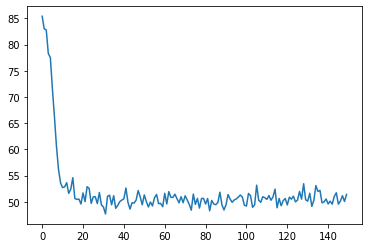

In [0]:
plt.plot(epoch_losses)

Train Test Accurcay 

In [0]:
with torch.no_grad():

  net.eval()
  y_pred = net(X_train.to(device))
  y_train = y_train.to(device)

  print(y_pred.shape)
  print(y_pred)
  print(y_train)


  correct = (y_pred.max(dim=1)[1] == y_train) 
  print('Train Acc')
  print(torch.mean(correct.float()).item())

with torch.no_grad():

  net.eval()
  y_pred = net(X_test.to(device))
  y_test = y_test.to(device)

  print(y_pred.shape)
  correct = (y_pred.max(dim=1)[1] == y_test) 
  print('Test Acc')
  print(torch.mean(correct.float()).item())



torch.Size([3231, 1])
tensor([[0.0185],
        [0.9954],
        [0.9727],
        ...,
        [0.9888],
        [0.0379],
        [0.0219]], device='cuda:0')
tensor([[0.],
        [1.],
        [1.],
        ...,
        [1.],
        [0.],
        [0.]], device='cuda:0')
Train Acc
0.5032497644424438
torch.Size([1385, 1])
Test Acc
0.471480131149292


Eventually export with ONNX (not working do do not export anything)

In [0]:
#Save model (next export it)

PATH = path+'net.pth'
torch.save(net.state_dict(), PATH)